In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

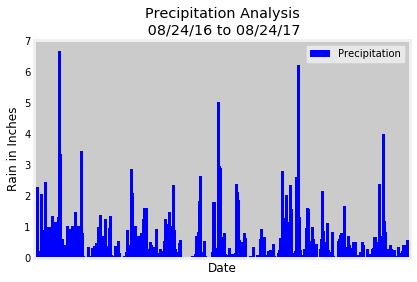

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
datequery = session.query(Measurement.id, Measurement.date, Measurement.prcp).filter(Measurement.date.between('2016-08-23', '2017-08-23')).order_by(Measurement.date).all()
# datequery

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(datequery)
# precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot.bar('date', 'prcp', width=18, color='blue')
plt.xlabel('Date')
plt.tick_params (
    axis = 'x',
    which = "both",
    bottom = True,
    top = False,
    labelbottom = False)
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis\n 08/24/16 to 08/24/17")
plt.legend(["Precipitation"])
plt.grid(True)
plt.savefig("Images/Precipitation Analysis.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,id,prcp
count,2230.000000,2021.000000
mean,10158.570404,0.177279
std,5603.500203,0.461190
min,2364.000000,0.000000
25%,5287.250000,0.000000
50%,8930.500000,0.020000
75%,14750.750000,0.130000
max,19550.000000,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
stationquery = session.query(Station.station, Station.station).count()
print(f"Total number of stations: {stationquery}")

Total number of stations: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
# activeStations.all()

activeStationsList = list(activeStations)
activeStations_df = pd.DataFrame(activeStationsList, columns = ['Station', 'Count'])
activeStations_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowestTemperature = session.query(func.min(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(f"The lowest temperature recorded is: {lowestTemperature}")

highestTemperature = session.query(func.max(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(f"The highest temperature recorded is: {highestTemperature}")

averageTemperature = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(f"The average temperature recorded is: {averageTemperature}")

The lowest temperature recorded is: (54.0,)
The highest temperature recorded is: (85.0,)
The average temperature recorded is: (71.66378066378067,)


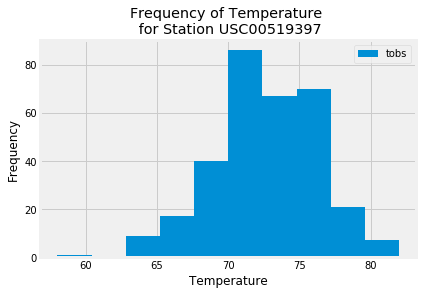

In [15]:
# Choose the station with the highest number of temperature observations.
highestTemperatureStation = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.prcp > 0).first()
highestTemperatureStation

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempsObserved12Months = session.query(Measurement.date, Measurement.tobs).filter(Measurement.prcp > 0).filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()
tempsObserved12Months_dict = dict(tempsObserved12Months)
tempsObserved12Months_dates = list(tempsObserved12Months_dict.keys())
tempsObserved12Months_temps = list(tempsObserved12Months_dict.values())

plt.hist(tempsObserved12Months_temps)
plt.title("Frequency of Temperature \n for Station USC00519397")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'])
plt.savefig("Images/Frequency of Temperature \n for Station USC00519397.png")
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    resultsList = list(np.ravel(results))
    
    return resultsList

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[62.0, 69.57142857142857, 74.0]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min_avg_max_temps = calc_temps('2016-08-23', '2017-08-23')
tmin = min_avg_max_temps[0]
tave = min_avg_max_temps[1]
tmax = min_avg_max_temps[2]

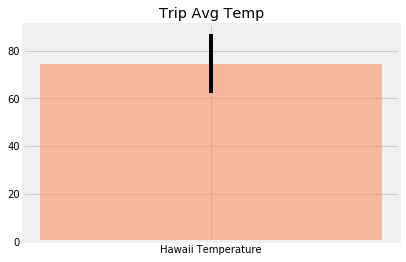

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y valueh
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = ["Hawaii Temperature"]
yerr = tmax - tave

plt.bar(x, tave, color="coral", alpha=0.5, yerr=yerr)
plt.title("Trip Avg Temp")
plt.savefig("Images/Trip Avg Temp.png")
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfallPerStation = session.query(Station.name, Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude).group_by(Measurement.station).filter(Station.station == Measurement.station).filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

rainfall_df = pd.DataFrame(rainfallPerStation, columns = ['Name', 'Station', 'Rainfall', 'Latitude', 'Longitude'])
rainfall_df

,Name,Station,Rainfall,Latitude,Longitude
0,"KANEOHE 838.1, HI US",USC00513117,48.51,21.42340,-157.80150
1,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,33.24,21.52130,-157.83740
2,"MANOA LYON ARBO 785.2, HI US",USC00516128,147.81,21.33310,-157.80250
3,"PEARL CITY, HI US",USC00517948,4.59,21.39340,-157.97510
4,"WAIHEE 837.5, HI US",USC00519281,70.03,21.45167,-157.84889
5,"WAIKIKI 717.2, HI US",USC00519397,16.09,21.27160,-157.81680
6,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,38.01,21.33556,-157.71139
